### Code d'implémentation en informatique classique et quantique d'une instance du TSP

Source : https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html

In [1]:
import time
from carbontracker.tracker import CarbonTracker
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from qiskit.circuit.library import n_local
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Tsp
from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE
from qiskit_optimization.optimizers import SPSA
from qiskit_optimization.utils import algorithm_globals
from qiskit_optimization.converters import QuadraticProgramToQubo
from itertools import permutations

In [2]:
# Fonction d'affichage du TSP sous forme de graphe complet, non orienté, pondéré
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

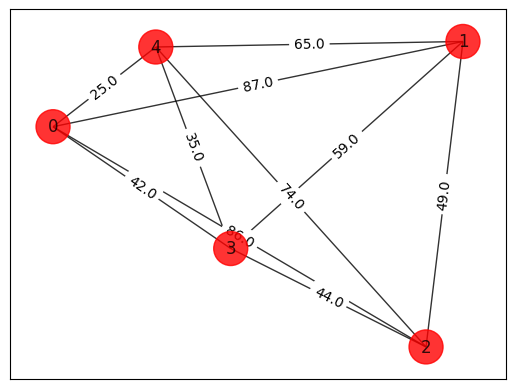

In [4]:
# Instance du TSP à 5 villes
n = 5
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=184)
adj_matrix = nx.to_numpy_array(tsp.graph)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)


In [5]:
def brute_force_tsp(w, N):
    a = list(permutations(range(1, N))) # Liste de toutes les (n-1)! permutations possibles
    last_best_distance = 1e10 # Définition d'une distance large (10^10) que l'on cherche a optimiser 
    
    for i in a : # Pour chaque permutation
        distance = 0
        pre_j = 0 # Sommet de départ
        for j in i: # Pour chaque sommet
            distance = distance + w[j, pre_j] # Ajout du coût de l'arête traversée à la variable distance
            pre_j = j # Somme actuel
    
        distance = distance + w[pre_j, 0] # Ajout du coût de retour à la ville de départ
        order = (0,) + i # Ajout de la ville de départ au cycle
        
        if distance < last_best_distance : # Si la distance est inférieure à la dernière meilleure distance
            best_order = order # Le cycle devient le meilleur cycle
            last_best_distance = distance # La distance devient la meilleure dernière distance
            print("order = " + str(order) + " Distance = " + str(distance)) 
            # Affichage des cycles qui battent la meilleure dernière distance
    return last_best_distance, best_order

In [6]:
best_distance, best_order = brute_force_tsp(adj_matrix, n)
# La matrice adj_matrix contient les distances entre les sommets i et j

print("Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance))

order = (0, 1, 2, 3, 4) Distance = 240.0
order = (0, 3, 2, 1, 4) Distance = 225.0
Best order from brute force = (0, 3, 2, 1, 4) with total distance = 225.0


In [7]:
# Fonction d'affichage de résolution du TSP sous forme de cycle hamiltonien orienté pondéré
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

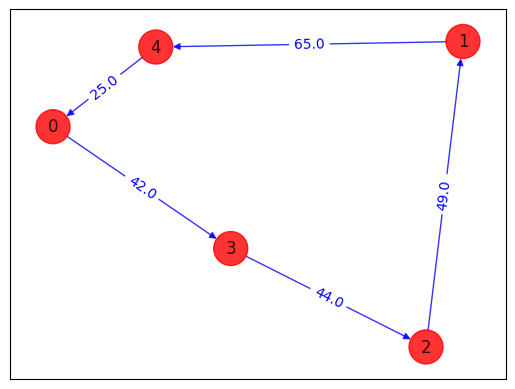

In [8]:
draw_tsp_solution(tsp.graph, best_order, colors, pos)

On souhaite désormais transformer le TSP en un problème **Ising** ou **QUBO** (Quadratic Unconstrained Binary Optimization). Le concept est le suivant : on encode une variable binaire $x_{i,p}$ qui vaut $1$ si la ville $i$ est visitée à la position $p$ du cycle, et $0$ sinon. On a donc $n^2$ varibales binaires et chaque chemin complet est une matrice contenant exactement un $1$ dans chaque ligne et chaque colonne.

In [9]:
# Correspondance avec le problème d'Ising 
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  87*x_0_0*x_1_1 + 87*x_0_0*x_1_4 + 86*x_0_0*x_2_1 + 86*x_0_0*x_2_4
  + 42*x_0_0*x_3_1 + 42*x_0_0*x_3_4 + 25*x_0_0*x_4_1 + 25*x_0_0*x_4_4
  + 87*x_0_1*x_1_0 + 87*x_0_1*x_1_2 + 86*x_0_1*x_2_0 + 86*x_0_1*x_2_2
  + 42*x_0_1*x_3_0 + 42*x_0_1*x_3_2 + 25*x_0_1*x_4_0 + 25*x_0_1*x_4_2
  + 87*x_0_2*x_1_1 + 87*x_0_2*x_1_3 + 86*x_0_2*x_2_1 + 86*x_0_2*x_2_3
  + 42*x_0_2*x_3_1 + 42*x_0_2*x_3_3 + 25*x_0_2*x_4_1 + 25*x_0_2*x_4_3
  + 87*x_0_3*x_1_2 + 87*x_0_3*x_1_4 + 86*x_0_3*x_2_2 + 86*x_0_3*x_2_4
  + 42*x_0_3*x_3_2 + 42*x_0_3*x_3_4 + 25*x_0_3*x_4_2 + 25*x_0_3*x_4_4
  + 87*x_0_4*x_1_0 + 87*x_0_4*x_1_3 + 86*x_0_4*x_2_0 + 86*x_0_4*x_2_3
  + 42*x_0_4*x_3_0 + 42*x_0_4*x_3_3 + 25*x_0_4*x_4_0 + 25*x_0_4*x_4_3
  + 49*x_1_0*x_2_1 + 49*x_1_0*x_2_4 + 59*x_1_0*x_3_1 + 59*x_1_0*x_3_4
  + 65*x_1_0*x_4_1 + 65*x_1_0*x_4_4 + 49*x_1_1*x_2_0 + 49*x_1_1*x_2_2
  + 59*x_1_1*x_3_0 + 59*x_1_1*x_3_2 + 65*x_1_1*x_4_0 + 65*x_1_1*x_4_2
  + 49*x_1_2*x_2_1 + 49*x_1_2*x_2_3 + 59*x_1_2*x_3_1 + 59*x_1_2*

Les contraintes d'assignation linéaires que l'on voit apparaître permettent de garantir que chaque ville n'apparait q'une seule fois dans la solution et que chaque position ne contient qu'une seule ville. Elles permettent de garantir que les conditions d'énonciation du problème sont bien vérifiées et que la solution est un permutation.

La fonction **minimize** est la fonction de coût que va chercher à minimiser l'algorithme. Elle se décompose en somme de coût de trajet entre deux positions succesives de la forme  : $w_{ij} * x_{i,p} * x_{j,p+1}$

Par exemple : $ 48 * x_{0,0} * x_{1,1} $ correspond au coût pour aller de la ville 0 en position 0, à la ville 1 en position 1.

La résolution de la fonction **minimize** donne le coût et l'ordre du cycle hamiltoninen recherché.

In [10]:
# Transformation d'un programme quadratique avec contraintes en un problème QUBO

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 199550.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIIZIIIIIZ', 'IIIIIIIIIIIIIIIZIIIIIIIIZ', 'IIIIIIIIIIIIIIZIIIII

Pour passer d'un programme quadratique avec contraintes à un problème QUBO, les contraintes linéaires précédentes doivent être encodées sous forme de pénalités.  
Par exemple :  $x_{0,0} + x_{0,1}+x_{0,2} =1 \ \textrm{  devient  } \ λ(x_{0,0}+x_{0,1}+x_{0,2}−1)^2$

On obtient alors une unique matrice $Q$ combinant coût et pénalité, de sorte que le problème QUBO s'exprime comme une minimisation de $x^T Qx$

Enfin, le QUBO est transformé en un Hamiltonien Ising. Pour cela, chaque variable $x_{i} ∈ \{0,1\}$ est transformée en spins $𝑧_{𝑖} ∈\{−1,+1\}$.

On obtient un hamiltonien exprimé comme une mutliplication de coefficients et d'opérateurs de Pauli.

In [11]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 225.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_0_4=0.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_1_3=0.0, x_1_4=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_2_4=0.0, x_3_0=0.0, x_3_1=0.0, x_3_2=1.0, x_3_3=0.0, x_3_4=0.0, x_4_0=0.0, x_4_1=0.0, x_4_2=0.0, x_4_3=0.0, x_4_4=1.0
status: SUCCESS


energy: -199325.0
tsp objective: 225.0
feasible: True
solution: [1, 2, 3, 0, 4]
solution objective: 225.0


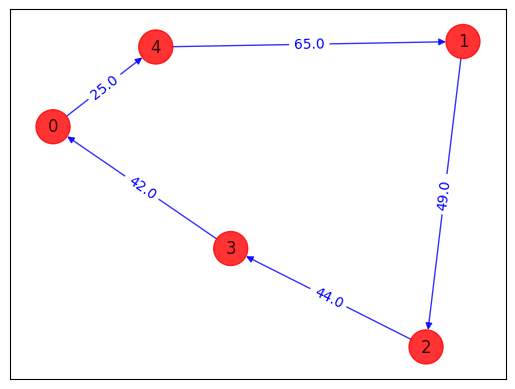

In [12]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)